In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 4.7 MB/s 
     |████████████████████████████████| 308 kB 42.9 MB/s 
     |████████████████████████████████| 100 kB 10.7 MB/s 
     |████████████████████████████████| 11.2 MB 32.1 MB/s 
     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 283 kB 39.8 MB/s 
     |████████████████████████████████| 81 kB 5.8 MB/s 
     |████████████████████████████████| 209 kB 11.3 MB/s 
     |████████████████████████████████| 965 kB 38.7 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 78 kB 4.2 MB/s 
     |████████████████████████████████| 112 kB 40.3 MB/s 
     |████████████████████████████████| 147 kB 43.5 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=50b9b6a3

In [161]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [156]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')




In [162]:
# Descarga de datos
# ==============================================================================
arch = ('/content/drive/MyDrive/Colab Notebooks/completo_ok.csv')
datos = pd.read_csv(arch, sep=',')
datos.info()
datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7295 non-null   int64  
 1   Fecha        7295 non-null   object 
 2   Dia          7295 non-null   int64  
 3   Demanda      7295 non-null   int64  
 4   Temperatura  7295 non-null   float64
 5   Feriado      7295 non-null   int64  
 6   Publico      7295 non-null   int64  
 7   Unnamed: 7   1 non-null      object 
dtypes: float64(1), int64(5), object(2)
memory usage: 456.1+ KB


,ID,Fecha,Dia,Demanda,Temperatura,Feriado,Publico,Unnamed: 7
0,0,2021/07/01 00:00,4,1721748533,8.7,0,0,NaN
1,1,2021/07/01 01:00,4,1731462994,8.4,0,0,NaN
2,2,2021/07/01 02:00,4,1676358588,8.2,0,0,NaN
3,3,2021/07/01 03:00,4,1653972981,7.7,0,0,NaN
4,4,2021/07/01 04:00,4,1653886127,7.2,0,0,NaN
...,...,...,...,...,...,...,...,...
7290,7290,2022/04/30 20:00,6,629897625,13.6,0,1793,NaN
7291,7291,2022/04/30 21:00,6,5189556589,12.2,0,0,NaN
7292,7292,2022/04/30 22:00,6,427229332,11.1,0,0,NaN
7293,7293,2022/04/30 23:00,6,3635388719,10.2,0,0,NaN


In [163]:
datos['Dia'].value_counts()

4    1056
6    1056
5    1055
7    1033
1    1032
3    1032
2    1031
Name: Dia, dtype: int64

In [164]:
datos['Demanda'] = pd.to_numeric(datos['Demanda'],errors = 'coerce')
datos.info()
datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7295 non-null   int64  
 1   Fecha        7295 non-null   object 
 2   Dia          7295 non-null   int64  
 3   Demanda      7295 non-null   int64  
 4   Temperatura  7295 non-null   float64
 5   Feriado      7295 non-null   int64  
 6   Publico      7295 non-null   int64  
 7   Unnamed: 7   1 non-null      object 
dtypes: float64(1), int64(5), object(2)
memory usage: 456.1+ KB


,ID,Fecha,Dia,Demanda,Temperatura,Feriado,Publico,Unnamed: 7
0,0,2021/07/01 00:00,4,1721748533,8.7,0,0,NaN
1,1,2021/07/01 01:00,4,1731462994,8.4,0,0,NaN
2,2,2021/07/01 02:00,4,1676358588,8.2,0,0,NaN
3,3,2021/07/01 03:00,4,1653972981,7.7,0,0,NaN
4,4,2021/07/01 04:00,4,1653886127,7.2,0,0,NaN
...,...,...,...,...,...,...,...,...
7290,7290,2022/04/30 20:00,6,629897625,13.6,0,1793,NaN
7291,7291,2022/04/30 21:00,6,5189556589,12.2,0,0,NaN
7292,7292,2022/04/30 22:00,6,427229332,11.1,0,0,NaN
7293,7293,2022/04/30 23:00,6,3635388719,10.2,0,0,NaN


In [150]:


datos.rename(columns={'TOTAL KW':'Demanda'}, inplace=True)

datos.info

<bound method DataFrame.info of         ID        FECHA/HORA  Dia    TOTAL_KW  TEMPERATURA  Feriado  Publico
0        0  01/07/2021 00:00    4  1721748533          8.7        0        0
1        1  01/07/2021 01:00    4  1731462994          8.4        0        0
2        2  01/07/2021 02:00    4  1676358588          8.2        0        0
3        3  01/07/2021 03:00    4  1653972981          7.7        0        0
4        4  01/07/2021 04:00    4  1653886127          7.2        0        0
...    ...               ...  ...         ...          ...      ...      ...
7241  7289  30/04/2022 19:00    6  6739928122         15.6        0     1916
7242  7290  30/04/2022 20:00    6   629897625         13.6        0     1793
7243  7291  30/04/2022 21:00    6  5189556589         12.2        0        0
7244  7292  30/04/2022 22:00    6   427229332         11.1        0        0
7245  7293  30/04/2022 23:00    6  3635388719         10.2        0        0

[7246 rows x 7 columns]>

In [165]:
# Conversión del formato fecha
# ==============================================================================
#datos.rename(columns={'FECHA/HORA':'Fecha'}, inplace=True)
#datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%dT%H:%M:%SZ')
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
#datos['FECHA/HORA'] = datos['FECHA/HORA'].dt.strftime('%Y/%m/%dt %H:%M')
datos = datos.set_index('Fecha')
datos = datos.asfreq('60min')
datos = datos.sort_index()
datos

,ID,Dia,Demanda,Temperatura,Feriado,Publico,Unnamed: 7
Fecha,,,,,,,
2021-07-01 00:00:00,0.0,4.0,1.721749e+09,8.7,0.0,0.0,NaN
2021-07-01 01:00:00,1.0,4.0,1.731463e+09,8.4,0.0,0.0,NaN
2021-07-01 02:00:00,2.0,4.0,1.676359e+09,8.2,0.0,0.0,NaN
2021-07-01 03:00:00,3.0,4.0,1.653973e+09,7.7,0.0,0.0,NaN
2021-07-01 04:00:00,4.0,4.0,1.653886e+09,7.2,0.0,0.0,NaN
...,...,...,...,...,...,...,...
2022-04-30 20:00:00,7290.0,6.0,6.298976e+08,13.6,0.0,1793.0,NaN
2022-04-30 21:00:00,7291.0,6.0,5.189557e+09,12.2,0.0,0.0,NaN
2022-04-30 22:00:00,7292.0,6.0,4.272293e+08,11.1,0.0,0.0,NaN


In [166]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [167]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2021-07-01 00:00:00': '2022-05-01 00:00:00']
fin_train = '2021-10-31 23:59:00'
fin_validacion = '2021-12-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2021-07-01 00:00:00 --- 2021-10-31 23:00:00  (n=2952)
Fechas validacion : 2021-11-01 00:00:00 --- 2021-12-30 23:00:00  (n=1440)
Fechas test       : 2021-12-31 00:00:00 --- 2022-05-01 00:00:00  (n=2905)


In [168]:
datos_train

,ID,Dia,Demanda,Temperatura,Feriado,Publico,Unnamed: 7
Fecha,,,,,,,
2021-07-01 00:00:00,0.0,4.0,1.721749e+09,8.7,0.0,0.0,NaN
2021-07-01 01:00:00,1.0,4.0,1.731463e+09,8.4,0.0,0.0,NaN
2021-07-01 02:00:00,2.0,4.0,1.676359e+09,8.2,0.0,0.0,NaN
2021-07-01 03:00:00,3.0,4.0,1.653973e+09,7.7,0.0,0.0,NaN
2021-07-01 04:00:00,4.0,4.0,1.653886e+09,7.2,0.0,0.0,NaN
...,...,...,...,...,...,...,...
2021-10-31 19:00:00,2947.0,7.0,7.965695e+09,17.2,0.0,1574.0,NaN
2021-10-31 20:00:00,2948.0,7.0,7.332867e+09,15.1,0.0,1385.0,NaN
2021-10-31 21:00:00,2949.0,7.0,4.236333e+08,14.3,0.0,0.0,NaN


In [40]:
!pip install matplotlib==3.1.3



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skforecast 0.5.1 requires matplotlib<=3.5,>=3.3, but you have matplotlib 3.1.3 which is incompatible.


In [41]:
import matplotlib.pyplot as plt

In [42]:
from sklearn.model_selection import train_test_split

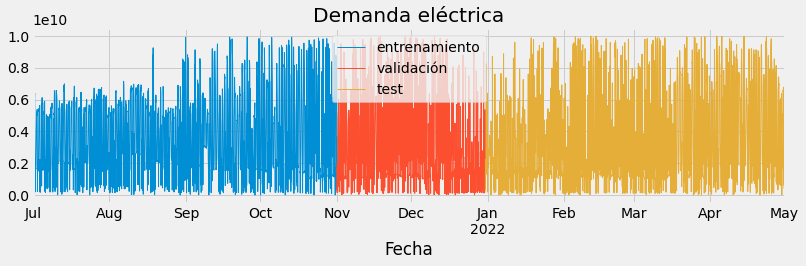

In [171]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
datos_train.Demanda.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demanda.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demanda.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

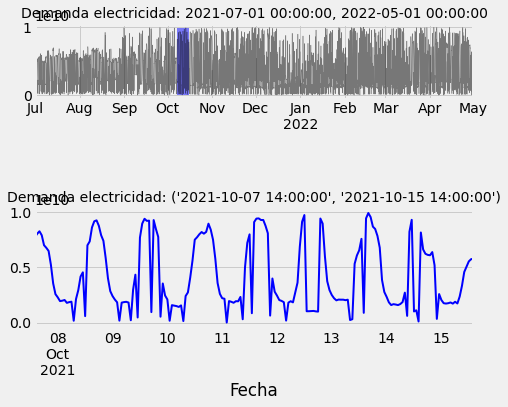

In [173]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2021-10-07 14:00:00','2021-10-15 14:00:00')

fig = plt.figure(figsize=(7, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demanda.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demanda)
max_y = max(datos.Demanda)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demanda.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

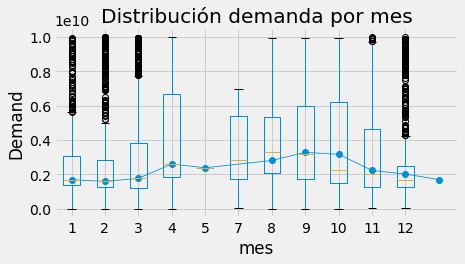

In [182]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demanda', by='mes', ax=ax,)
datos.groupby('mes')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

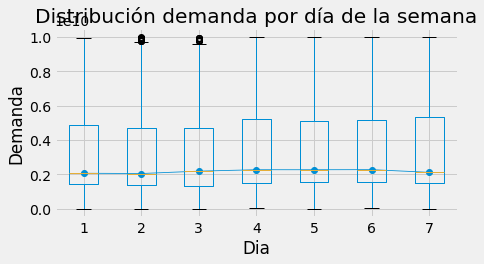

In [183]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['Dia'] = datos.index.day_of_week + 1
datos.boxplot(column='Demanda', by='Dia', ax=ax)
datos.groupby('Dia')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

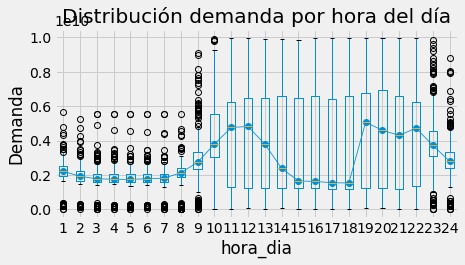

In [185]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demanda', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

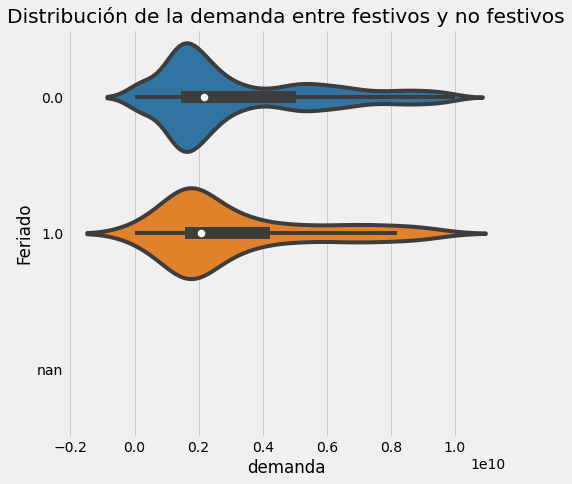

In [186]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
sns.violinplot(
    x       = 'Demanda',
    y       = 'Feriado',
    data    = datos.assign(Feriado = datos.Feriado.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('Feriado');

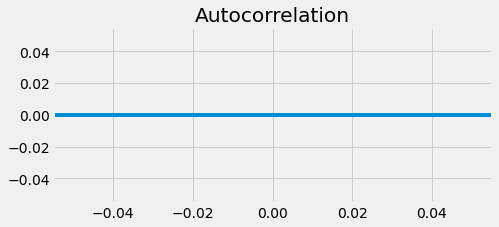

In [187]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.Demanda, ax=ax, lags=60)
plt.show()

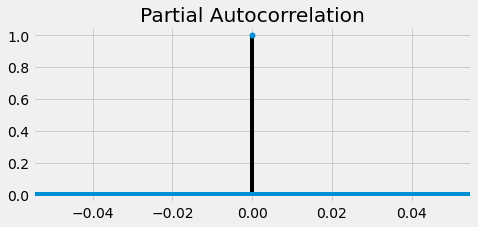

In [188]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.Demanda, ax=ax, lags=60)
plt.show()


In [195]:
datos.loc[:fin_validacion, 'Demanda']

Fecha
2021-07-01 00:00:00    1.721749e+09
2021-07-01 01:00:00    1.731463e+09
2021-07-01 02:00:00    1.676359e+09
2021-07-01 03:00:00    1.653973e+09
2021-07-01 04:00:00    1.653886e+09
                           ...     
2021-12-30 19:00:00    1.528912e+09
2021-12-30 20:00:00    1.463402e+09
2021-12-30 21:00:00    9.282747e+08
2021-12-30 22:00:00    5.367104e+09
2021-12-30 23:00:00    3.807065e+08
Freq: 60T, Name: Demanda, Length: 4392, dtype: float64

In [197]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
              )

forecaster.fit(y=datos.loc['2021-07-01 00:00:00':'2021-10-31 23:00:00', 'Demanda'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-07-01 00:00:00'), Timestamp('2021-10-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-11-24 23:20:33 
Last fit date: 2022-11-24 23:20:33 
Skforecast version: 0.5.1 
Python version: 3.7.15 

In [73]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 5.3 MB/s 


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0e1e698250>)

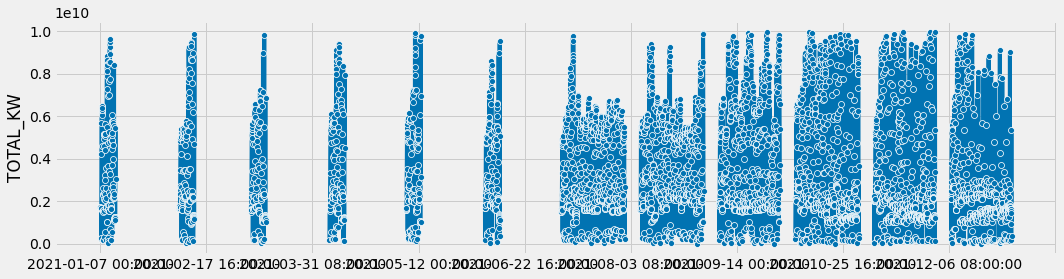

In [81]:
from sktime.utils.plotting import plot_series
plot_series(y)


In [284]:
# Backtest
# ==============================================================================
predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demanda,
                            initial_train_size =2927,
                            fixed_train_size   = False,
                            steps      = 23,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2927
Number of observations used for backtesting: 4370
    Number of folds: 190
    Number of steps per fold: 23

Data partition in fold: 0
    Training:   2021-07-01 00:00:00 -- 2021-10-30 22:00:00  (n=2927)
    Validation: 2021-10-30 23:00:00 -- 2021-10-31 21:00:00  (n=23)
Data partition in fold: 1
    Training:   2021-07-01 00:00:00 -- 2021-10-30 22:00:00  (n=2927)
    Validation: 2021-10-31 22:00:00 -- 2021-11-01 20:00:00  (n=23)
Data partition in fold: 2
    Training:   2021-07-01 00:00:00 -- 2021-10-30 22:00:00  (n=2927)
    Validation: 2021-11-01 21:00:00 -- 2021-11-02 19:00:00  (n=23)
Data partition in fold: 3
    Training:   2021-07-01 00:00:00 -- 2021-10-30 22:00:00  (n=2927)
    Validation: 2021-11-02 20:00:00 -- 2021-11-03 18:00:00  (n=23)
Data partition in fold: 4
    Training:   2021-07-01 00:00:00 -- 2021-10-30 22:00:00  (n=2927)
    Validation: 2021-11

ValueError: ignored

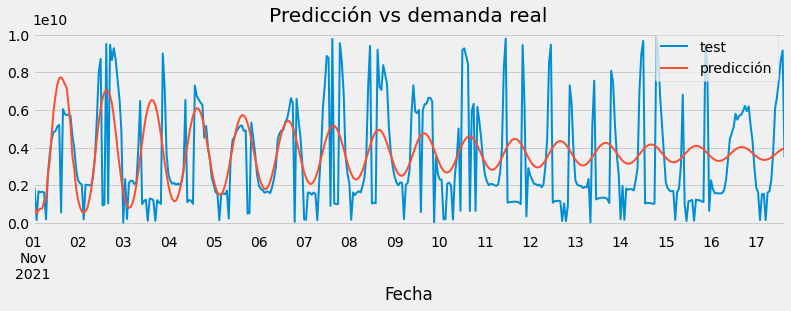

In [285]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demanda'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [286]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

NameError: ignored

In [287]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()# Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'Demanda'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(datos[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30.


loop lags_grid:   0%|                                               | 0/3 [00:00<?, ?it/s]


ValueError: ignored

In [288]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

NameError: ignored

In [289]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=0.001) 
Lags: [1 2 3 4 5] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-11-25 02:14:59 
Last fit date: None 
Skforecast version: 0.5.1 
Python version: 3.7.15 

In [290]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.Demand,
                            initial_train_size = len(datos[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            verbose            = False
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

AttributeError: ignored

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

In [291]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos.Demand,
                            initial_train_size  = len(datos.Demand[:fin_validacion]),
                            fixed_train_size    = False,
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

print('Métrica backtesting:', metric)
predicciones.head(5)

AttributeError: ignored

KeyError: ignored

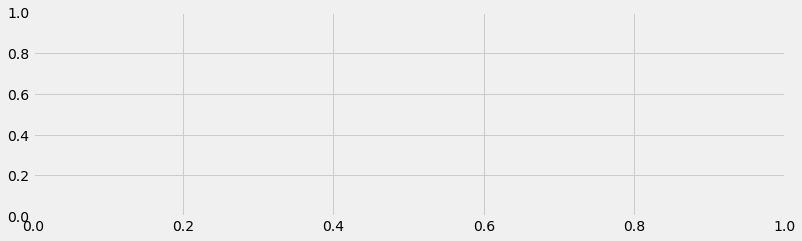

In [292]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción' 
)
ax.legend();

In [294]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[fin_validacion:, 'Demanda'] >= predicciones['lower_bound']) & \
                     (datos.loc[fin_validacion:, 'Demanda'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

KeyError: ignored

In [295]:
def backtest_predict_next_24h(forecaster, y, hour_init_prediction, exog=None,
                              verbose=False):
    
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg 
        ForecasterAutoreg object already trained.
        
    y : pd.Series with datetime index sorted
        Test time series values. 
        
    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable. 
    
    hour_init_prediction: int 
        Hour of day D to start predicciones of day D+1.


    Returns 
    -------
    predicciones: pd.Series
        Value of predicciones.

    '''
    
    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()
        
    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24
    
    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break
    
    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predicciones = []
    
    for i, day in enumerate(days_backtest):        
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]
               
        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")
                
            pred = forecaster.predict(steps=steps, last_window=last_window)
            
        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window
            
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")
            
            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predicciones of day D+1
        pred = pred[dummy_steps:]
        backtest_predicciones.append(pred)
    
    backtest_predicciones = np.concatenate(backtest_predicciones)
    # Add datetime index
    backtest_predicciones = pd.Series(
                             data  = backtest_predicciones,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )
    
    return backtest_predicciones

In [297]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demanda'],
                    hour_init_prediction = 11,
                    verbose    = False
                )

TypeError: ignored

KeyError: ignored

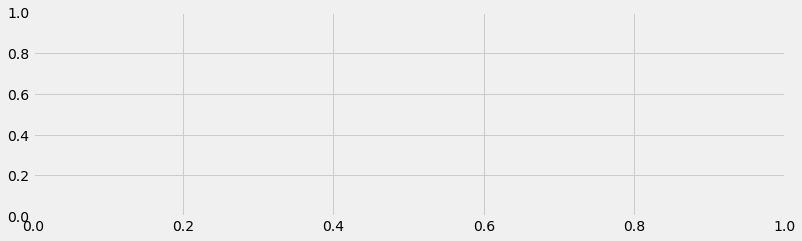

In [298]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [300]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demanda'],
            y_pred = predicciones
        )
print(f"Error de backtest: {error}")

Error de backtest: 1968863400.380663


In [301]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importance()

NotFittedError: ignored

In [ ]:
# Se convierte la columna Holiday de boolean a integer
datos_train.loc[:,'Feriado'] = datos_train['Feriado'].astype(int)
datos_test.loc[:,'Feriado'] = datos_test['Feriado'].astype(int)

# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )



forecaster.fit(y=datos.Demand[:fin_validacion], exog=datos.Holiday[:fin_validacion])
forecaster

In [ ]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    exog       = datos.loc[fin_validacion:, 'Feriado'],
                    hour_init_prediction = 11,
                    verbose    = False
               )

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'TOTAL KW'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

In [ ]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos.loc[:,'Feriado_antes'] = datos['Feriado'].shift(24)
datos.loc[:,'Feriado_despues']   = datos['Feriado'].shift(-24)
datos=datos.dropna()

# One hot encoding del día de la semana y la hora del día
datos=pd.get_dummies(datos, columns=['dia_semana', 'hora_dia'])
datos.head(3)

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Feriado'))]
forecaster.fit(y=datos.Demand[: fin_validacion], exog=datos[exog][: fin_validacion])

# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'TOTAL KW'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Modelo direct multi-step


Los modelos ForecasterAutoreg siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir, lo que se conoce como direct multi-step forecasting. Si bien es computacionalmente más costosa que la recursiva, puesto que requiere entrenar múltiples modelos, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregDirect y pueden incluir también una o múltiples variables exógenas.

Entrenamiento y tuning del Forecaster


A diferencia de cuando se utiliza ForecasterAutoreg, en los modelos de tipo ForecasterAutoregDirect hay que indicar, en el momento de su creación, el número máximo de steps que se quieren predecir.

In [302]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor = LGBMRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'TOTAL KW'],
                        exog               = datos.loc[:fin_validacion, exog],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        initial_train_size = len(datos.loc[:fin_train]),
                        return_best        = True,
                        verbose            = False
                  )

NameError: ignored

In [ ]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

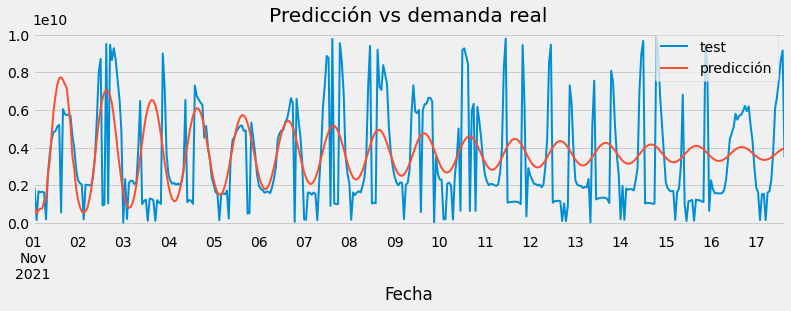

In [304]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demanda'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [306]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demanda'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 1968863400.380663
